# Some applications of convex optimization
(based on the examples from [CVXPY tutorial](https://www.cvxpy.org/examples/index.html))

In [1]:
import numpy as np
import cvxpy as cvx
print(cvx.installed_solvers())
import matplotlib.pyplot as plt

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'MOSEK', 'OSQP', 'SCS']


<img src="./cvxpy_solvers.png" width=1000>

## De-noising

- Image
- Sound

### Image

In [2]:
from PIL import Image

# np.random.seed(1)
# Load image
orig_img = Image.open("./kandinskiy_comp_viii.jpg")
# orig_img = Image.open("./lena_small.jpg")

# Convert to arrays
Uorig = np.array(orig_img)
rows, cols, colors = Uorig.shape
print(Uorig.shape)

# Known is 1 if the pixel is known,
# 0 if the pixel was corrupted
Known = np.zeros((rows, cols, colors))
for i in range(rows):
    for j in range(cols):
        if np.random.random() > 0.7:
            for k in range(colors):
                Known[i, j, k] = 1

# Create corrupted image
Ucorr = Known * Uorig
# Convert to image
corr_img = Image.fromarray(np.uint8(Ucorr))

(425, 640, 3)


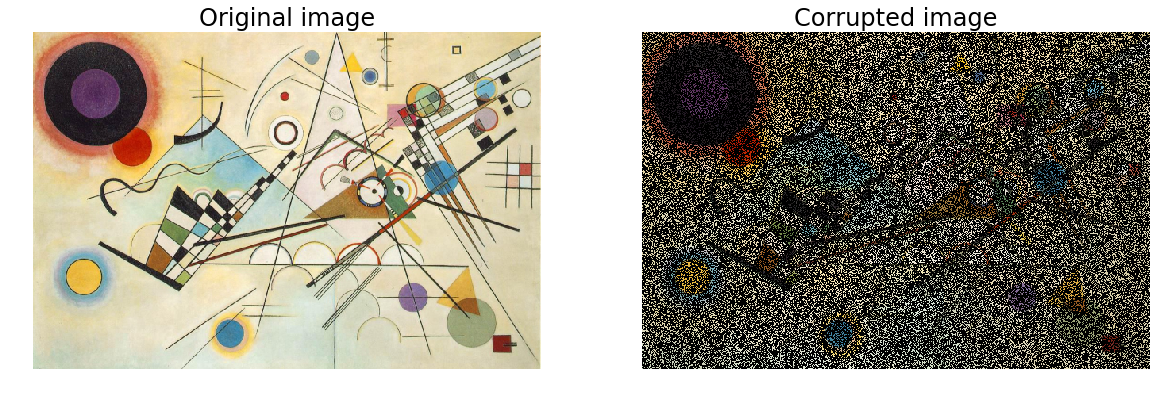

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(orig_img);
ax[0].set_title("Original image", fontsize=24)
ax[0].axis('off')
ax[1].imshow(corr_img);
ax[1].set_title("Corrupted image", fontsize=24)
ax[1].axis('off');

### Total variation

$$
\begin{align*}
& \min_{X} \sum_{i=1}^{m-1}\sum_{j=1}^{n-1} \left\|\left[ \begin{array}{} 
X_{i+1,j} - X_{ij} \\ X_{i, j+1} - X_{ij}\end{array} \right] \right\|_2\\
\text{s.t. } & X_{ij} = X^{known}_{ij}, \; (i, j) \in \mathcal{I}
\end{align*}
$$

- $\mathcal{I}$ is a set of indices with known values
- Gradient approximation is not squared

In [4]:
# Define variables and constraints
variables = []
constraints = []
for i in range(colors):
#     Slice of image tensor for the i-th color
    U = cvx.Variable(shape=(rows, cols))
#     Append to the list of variables
    variables.append(U)
#     Append constraints: known pixels in the given image 
#     has to be equal to the pixels in reconstructed image
    constraints.append(cvx.multiply(Known[:, :, i], U) == \
                       cvx.multiply(Known[:, :, i], Ucorr[:, :, i]))

In [5]:
# Create minimization problem with created constraints and solve it
prob = cvx.Problem(cvx.Minimize(cvx.tv(*variables)), constraints)
prob.solve(verbose=True, solver="SCS", max_iters=500)

WARN: A->p (column pointers) not strictly increasing, column 542935 empty
WARN: A->p (column pointers) not strictly increasing, column 814935 empty
WARN: A->p (column pointers) not strictly increasing, column 1086935 empty
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 3765819, CG tol ~ 1/iter^(2.00)
eps = 1.00e-04, alpha = 1.50, max_iters = 500, normalize = 1, scale = 1.00
Variables n = 1086936, constraints m = 2712552
Cones:	primal zero / dual free vars: 816000
	soc vars: 1896552, soc blks: 270936
Setup time: 2.61e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     

4587528.259568932

In [6]:
# Load variables values into array
rec_arr = np.zeros((rows, cols, colors), dtype=np.uint8)
for i in range(colors):
    rec_arr[:, :, i] = variables[i].value

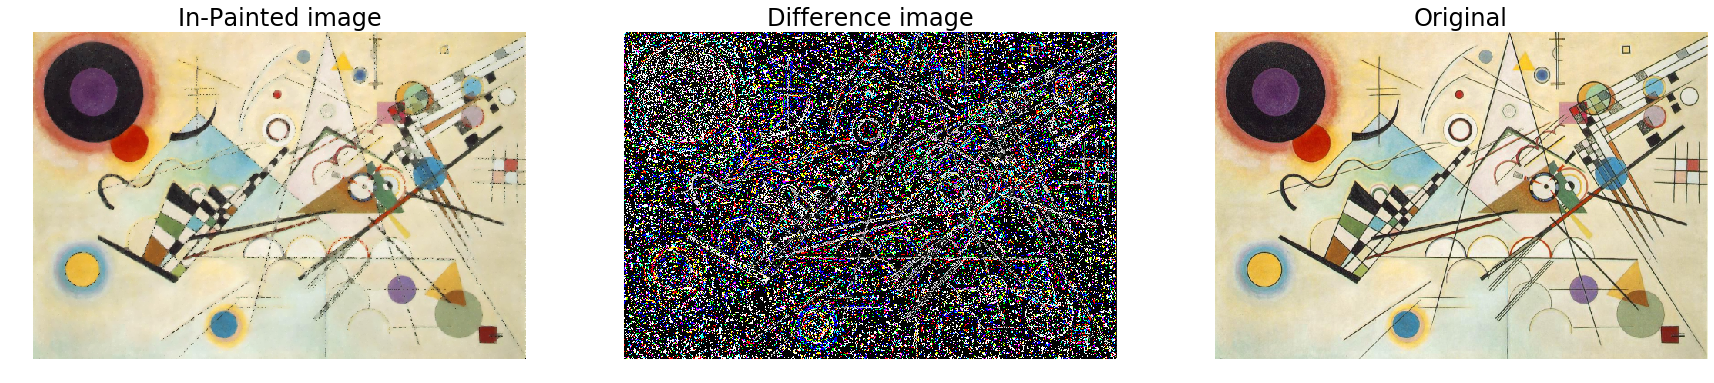

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(30, 20))
img_rec = Image.fromarray(rec_arr)
ax[0].imshow(img_rec);
ax[0].set_title("In-Painted image", fontsize=24)
ax[0].axis('off')

img_diff = Image.fromarray(np.abs(Uorig - rec_arr))
ax[1].imshow(img_diff);
ax[1].set_title("Difference image", fontsize=24)
ax[1].axis('off');

img_diff = Image.fromarray(Uorig)
ax[2].imshow(img_diff);
ax[2].set_title("Original", fontsize=24)
ax[2].axis('off');

### Sound

44100 (7636608,) <class 'numpy.int16'>
Problem dimension = 500000


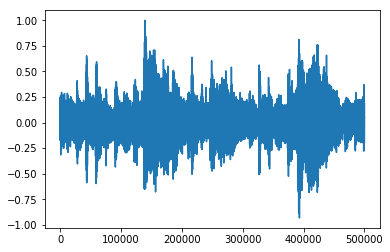

In [8]:
import scipy.io.wavfile as siowav
import IPython.display as ipd

# Load original track
sr, sound = siowav.read("./test_sound.wav")
print(sr, sound.shape, type(sound[0]))
start = 500000
fin = 1000000
sound = sound.astype("float32")
# Cut and normalize original track
sound = sound[start:fin] / np.max(sound[start:fin])
n = sound.shape[0]
print("Problem dimension = {}".format(n))
plt.plot(sound)
# plt.xscale("log")

In [9]:
ipd.Audio(sound, rate=sr)

1.0 -0.9321503 -5.616108e-06 0.15347655


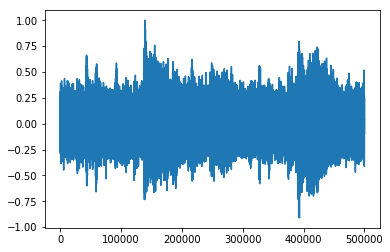

In [10]:
# Create corrupted signal and normalize it 
corrupt_sound = sound + 0.1 * np.random.randn(sound.shape[0])
corrupt_sound = corrupt_sound / np.max(np.abs(corrupt_sound))
plt.plot(corrupt_sound)
# plt.xscale("log")
print(sound.max(), sound.min(), sound.mean(), sound.std())

In [11]:
ipd.Audio(corrupt_sound, rate=sr)

#### $\ell_1$ regularization

$$
\begin{align*}
& \min_{x} \|x - x_c\|_2 + \lambda \sum_{i=1}^{n-1} |x_i - x_{i+1}|\\
\text{s.t. } & -1 \leq x_i \leq 1
\end{align*}
$$

In [12]:
# Create variable for reconstructed signal 
x_rec = cvx.Variable(corrupt_sound.shape[0])
# Create ac problem and solve it, \lambda = 1 
prob = cvx.Problem(cvx.Minimize(cvx.norm(x_rec - corrupt_sound) + 10 * cvx.tv(x_rec)),
                   [x_rec >= -1, x_rec <= 1])
prob.solve(verbose=True, solver=cvx.SCS, max_iters=500)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 4499995, CG tol ~ 1/iter^(2.00)
eps = 1.00e-04, alpha = 1.50, max_iters = 500, normalize = 1, scale = 1.00
Variables n = 1000000, constraints m = 2499999
Cones:	linear vars: 1999998
	soc vars: 500001, soc blks: 1
Setup time: 2.67e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf       nan      -inf       inf       inf  6.33e-01 
   100| 2.41e-03  3.09e-03  9.92e-01  1.29e+02 -0.00e+00  1.08e-09  1.56e+01 
   200| 1.77e-03  2.62e-03  1.37e-01  1.58e+02  2.08e+02  1.08e-09  3.31e+01 
   300| 1.47e-03

71.48900945800915

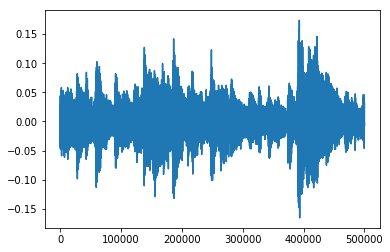

In [13]:
plt.plot(x_rec.value)

In [14]:
ipd.Audio(x_rec.value, rate=sr)

#### $\ell_2$-regularization

$$
\begin{align*}
& \min_{x} \|x - x_c\|_2 + \lambda \sum_{i=1}^{n-1} (x_i - x_{i+1})^2\\
\text{s.t. } & -1 \leq x_i \leq 1
\end{align*}
$$

In [27]:
# The same as in the previous cell, but with \ell_2 regularization 
x_rec = cvx.Variable(n)
prob = cvx.Problem(cvx.Minimize(cvx.norm(x_rec - corrupt_sound) + 
                                cvx.square(cvx.norm(x_rec[1:n] - x_rec[0:n-1]))),
                   [x_rec >= -1, x_rec <= 1])
prob.solve(verbose=True, solver="SCS", max_iters=500)

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 2500003, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 500, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 500003, constraints m = 2000004
Cones:	linear vars: 1000000
	soc vars: 1000004, soc blks: 3
Setup time: 1.51e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.60e+22  8.94e+21  1.00e+00 -6.75e+24  4.49e+23  5.02e+24  1.28e+00 
   100| 6.41e-03  5.96e-03  4.71e-04  7.58e+01  7.57e+01  1.67e-13  5.49e+01 
   200| 3.07e-04  2.71e-04  8.68e-04  7.56e+01  7

75.48107902807476

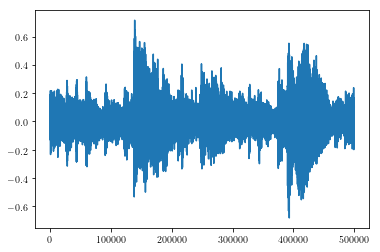

In [28]:
plt.plot(x_rec.value)

In [29]:
ipd.Audio(x_rec.value, rate=sr)

### Summary

- Different regularizations give different solutions
- Comparison of $\ell_1$ and $\ell_2$ regularizations
- The choice of $\lambda$ is important

## Control of linear dynamical system

- Given $x_1, u_1, u_2, \ldots$
- Find $x_2, x_3, \ldots$ recursively

$$
x_{t+1} = Ax_t + Bu_t
$$

- Example: motion of an object with friction

$$
m \frac{v_{t+1} - v_t}{\tau} \approx -\eta v_t + u_t \quad \frac{p_{t+1} - p_t}{\tau} \approx v_{t},
$$
 
where $v_{t} = (v^x_t, v^y_t)$ и $p_t = (p^x_t, p^y_t)$

We can derive the following approximation

$$
v_{t+1} = \left(1 - \frac{\tau}{m}\eta \right)v_t + \frac{\tau}{m}u_t \quad p_{t+1} = p_t + \tau v_t
$$

Or in standard form

$$
x_{t} = \begin{bmatrix} p^x_t \\ p^y_t \\ v^x_t \\ v^y_t \end{bmatrix} \quad A = \begin{bmatrix} 1 & 0 & \tau & 0 \\ 0 & 1 & 0 & \tau \\ 0 & 0 & 1 - \frac{\tau}{m}\eta & 0\\ 0 & 0 & 0 & 1 - \frac{\tau}{m}\eta  \end{bmatrix} \quad B = \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ \frac{\tau}{m} & 0 \\ 0 & \frac{\tau}{m} \end{bmatrix}
$$

### Control

- Given initial state $x_1$
- Find such $u_1, \ldots, u_T$, that some target is achieved
    - the final state $x_{target}$ is achieved
    - the minimal amount of "energy" is consumed

In [24]:
m = 1
eta = 0.1
tau = 0.01
T = 100
A = np.array([[1, 0, tau, 0], 
              [0, 1, 0, tau], 
              [0, 0, 1 - eta * tau / m, 0], 
              [0, 0, 0, 1 - eta * tau / m]])
B = np.array([[0, 0],
             [0, 0],
             [tau / m, 0],
             [0, tau / m]])

In [25]:
# Initialize original and target states of the defined system
x0 = np.array([5, 5, 20, -5])
x_target = np.array([0, 7, 0, 0])

In [26]:
# Create variables to store evolution of the system and 
# all control vectors
x = cvx.Variable((4, T + 1))
u = cvx.Variable((2, T))

states = []
for t in range(T):
#     Create objective function and constraints in every time step
    cost = cvx.sum_squares(u[:, t])
    constr = [x[:, t+1] == A*x[:, t] + B*u[:, t]]
    states.append(cvx.Problem(cvx.Minimize(cost), constr))
# Sum-up all problems: sum objectives and concatenate constraints 
prob0 = sum(states)
# Append original state and target state
complete_constr = prob0.constraints + [x[:,0] == x0, x[:, T] == x_target]
prob = cvx.Problem(prob0.objective, complete_constr)
prob.solve(verbose=True)

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 804, constraints m = 608
          nnz(P) + nnz(A) = 1808
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.00e+01   2.00e+03   1.00e-01   6.88e-04s
  75   3.3624e+05   9.28e-06   6.62e-10   9.18e+01   2.29e-03s

status:               solved
solution polis

336238.11033245263

Text(0, 0.5, '$y$')

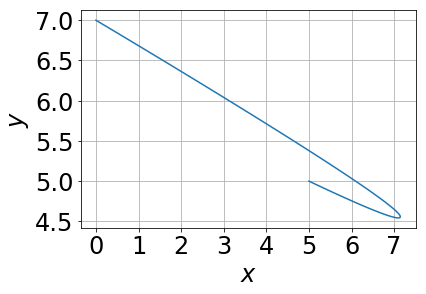

In [27]:
plt.plot(x.value[0, :], x.value[1, :])
plt.grid(True)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel(r"$x$", fontsize=24)
plt.ylabel(r"$y$", fontsize=24)

Text(0.5, 0, 'Time, $t$')

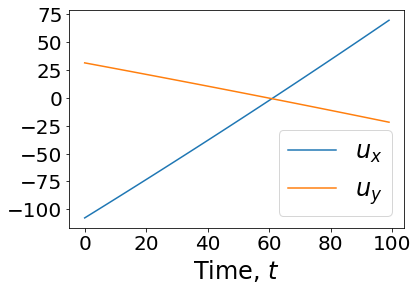

In [28]:
plt.plot(u.value[0, :], label=r"$u_x$")
plt.plot(u.value[1, :], label=r"$u_y$")
plt.legend(fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Time, $t$", fontsize=24)

### Rendezvous problem

- Given two bodies, every body has its own dynamic, i.e. matrices $A$ and $B$ are different and initial state and speed are also different
- Find $u_i$ and $v_i$ for every body such that their final state are equal and total amount of consumed energy is the minimal

#### Formal problem statement

$$
\begin{align*}
& \min \sum_{i=1}^T \|u_i\|_2^2 + \|v_i\|_2^2 \\
\text{s.t. } & x_{t+1} = Ax_t + Bu_t, \; t = 1,\ldots,T-1\\
& z_{t+1} = Cz_t + Dv_t, \; t = 1,\ldots,T-1\\
& x_T = z_T
\end{align*}
$$

In [29]:
m1 = 1
eta1 = 0.1
m2 = 1
eta2 = 1
tau = 0.01
T = 100
A = np.array([[1, 0, tau, 0], 
              [0, 1, 0, tau], 
              [0, 0, 1 - eta1 * tau / m1, 0], 
              [0, 0, 0, 1 - eta1 * tau / m1]])
B = np.array([[0, 0],
             [0, 0],
             [tau / m1, 0],
             [0, tau / m1]])

C = np.array([[1, 0, tau, 0], 
              [0, 1, 0, tau], 
              [0, 0, 1 - eta2 * tau / m2, 0], 
              [0, 0, 0, 1 - eta2 * tau / m2]])
D = np.array([[0, 0],
             [0, 0],
             [tau / m2, 0],
             [0, tau / m2]])

In [33]:
x0 = np.array([0, 0, 1, 1])
z0 = np.array([10, 0, 0.5, -0.5])

In [34]:
x = cvx.Variable((4, T + 1))
z = cvx.Variable((4, T + 1))
u = cvx.Variable((2, T))
v = cvx.Variable((2, T))

states = []
for t in range(T):
    cost = cvx.sum_squares(u[:, t]) + cvx.sum_squares(v[:, t])
    constr = [x[:, t+1] == A*x[:, t] + B*u[:, t], z[:, t+1] == C*z[:, t] + D*v[:, t]]
    states.append(cvx.Problem(cvx.Minimize(cost), constr))
prob0 = sum(states)
complete_constr = prob0.constraints + [x[:, T] == z[:, T], x[:, 0] == x0, z[:, 0] == z0]
prob = cvx.Problem(prob0.objective, complete_constr)
prob.solve(verbose=True)

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1608, constraints m = 1212
          nnz(P) + nnz(A) = 3616
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.00e+01   1.00e+03   1.00e-01   9.60e-04s
  75   5.9338e+04   1.12e-05   2.97e-09   5.95e+01   3.57e-03s

status:               solved
solution pol

59338.191281307336

(array([-0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25]),
 <a list of 8 Text yticklabel objects>)

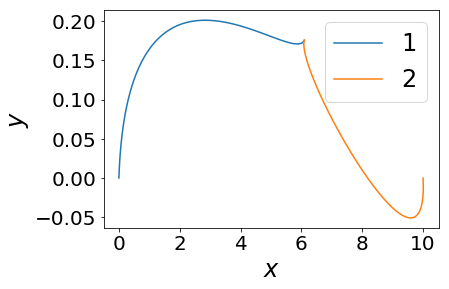

In [35]:
plt.plot(x.value[0, :], x.value[1, :], label="1")
plt.plot(z.value[0, :], z.value[1, :], label="2")
plt.legend(fontsize=24)
plt.xlabel(r"$x$", fontsize=24)
plt.ylabel(r"$y$", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

### HIstory and current stage

- The similar problems were solving to model the sputnik launch and spaceships.
- Nowadays SpaceX uses [CVXGEN](https://cvxgen.com/docs/index.html) to model accurate landing of their spacecrafts, [proof](https://www.nae.edu/19582/Bridge/164237/164334.aspx) 
- CVXGEN generates custom embedded code to solve the quadratic problems in device, more details see [here](http://stanford.edu/~boyd/papers/code_gen_rhc.html)

## The L&ouml;wner-John ellipsoid

**Problem**: given a set of points $x_i \in \mathbb{R}^2$, we need to find ellipsoid such that its square isthe minimal and all $x_i$ lie inside.

**Parameters**: 

$$
\{x \; | \; \| x \|^2_2 \leq 1\} \to \{ u \;| \; \|u\|^2_2 \leq 1, \; u = Ax + b\}
$$

Then square is factored by $\det (A^{-1})$. 

- determinant is not convex, nor concave function
- $\log\det(A^{-1}) = -\log\det(A)$ - convex function $A \in \mathbb{S}^n_{++}$

### Minimization problem

$$
\begin{align*}
& \min_{A, b} -\log\det(A)\\
\text{s.t. } & \|Ax_i + b\| \leq 1\\
& A \succ 0
\end{align*}
$$

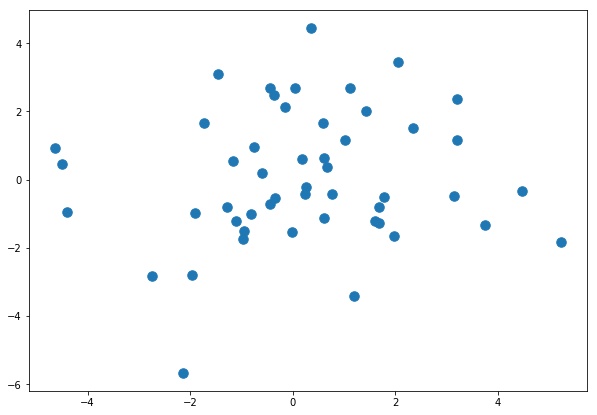

In [36]:
num_points = 50
n = 2
X = 2 * np.random.randn(n, num_points)
plt.figure(figsize=(10, 7))
plt.scatter(X[0, :], X[1, :], s=90)

In [37]:
# Create variables: positive semi-definite matrix A and vector b
A = cvx.Variable((n,n), PSD=True)
b = cvx.Variable((n,))
prob = cvx.Problem(cvx.Minimize(-cvx.log_det(A)), 
   [cvx.norm(A * X[:, i] + b) <= 1 for i in range(num_points)])

In [38]:
prob.solve(verbose=True)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 447, CG tol ~ 1/iter^(2.00)
eps = 1.00e-04, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 73, constraints m = 237
Cones:	primal zero / dual free vars: 15
	linear vars: 50
	soc vars: 150, soc blks: 50
	sd vars: 16, sd blks: 3
	exp vars: 6, dual exp vars: 0
Setup time: 1.69e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.17e+00  1.85e+00  9.22e-01 -9.03e+00  2.87e+00  6.18e-15  7.88e-01 
   100| 1.67e-02  5.80e-03  2.53e-03  3.11e+00  3.13e+00  1.16e-15  7.92e-01 
   200| 8.17e-03  2.99e

3.3126313762094033

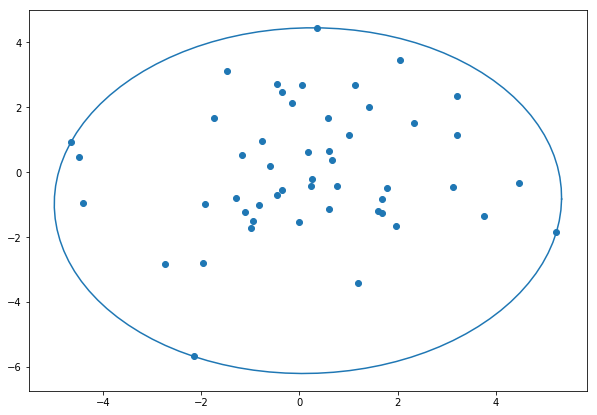

In [39]:
plt.figure(figsize=(10, 7))
plt.scatter(X[0, :], X[1, :])
phi = np.linspace(0, 2 * np.pi, num=100)
xy = np.vstack((np.cos(phi) - b.value[0], np.sin(phi) - b.value[1]))
ellips = np.linalg.solve(A.value, xy)
plt.plot(ellips[0, :], ellips[1, :])

## DCP rules and what exceptions arise if one violates some of the rule

In [70]:
x = cvx.Variable(2)
problem = cvx.Problem(cvx.Minimize(cvx.exp(-x[0])), [cvx.quad_over_lin(x[0], x[1]) <= 0])
problem.solve(solver="SCS", eps=1e-7, verbose=True)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 8, CG tol ~ 1/iter^(2.00)
eps = 1.00e-07, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 4, constraints m = 7
Cones:	linear vars: 1
	soc vars: 3, soc blks: 1
	exp vars: 3, dual exp vars: 0
Setup time: 2.64e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf       nan      -inf       inf       inf  1.63e-03 
   100| 5.34e-02  7.97e-02  8.84e-02  5.79e-01  7.89e-01  1.12e-16  2.46e-03 
   200| 1.84e-01  5.00e-01  2.68e-01 -3.67e-01 -0.00e+00  0.00e+00  2.80e-03 
   300| 1.90e

In [57]:
problem.value